# VAE with _Dense_ layers: PyTorch and MNIST

[Refer](https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.9.0


In [3]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

number of GPU(s) available = 0
PyTorch does not have access to GPU


In [4]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cpu


In [5]:
# Specify hyper-parameters-
num_epochs = 30
batch_size = 64
learning_rate = 0.001

### Load and pre-process MNIST dataset:

In [6]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [7]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        # root = './data', train = True,
        root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        # root = './data', train = False,
        root = path_to_data + "data", train = False,
        transform = transforms_apply
        )


C:\Users\Arjun\anaconda3\envs\pytorch-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 938 and test_loader: 157


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 938 & len(test_loader) = 157


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(937.5, 156.25)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 1, 28, 28]) & labels.shape: torch.Size([64])


In [14]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([64, 784])

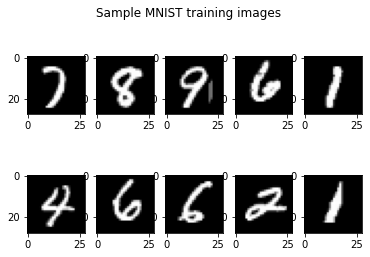

In [15]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

### Define _Variational Autoencoder_ architecture:

In [16]:
# Specify latent-space dimensions-
latent_space = 16

In [43]:
class VAE_Dense(nn.Module):
    def __init__(self):
        super(VAE_Dense, self).__init__()
        
        # Encoder-
        self.enc_layer1 = nn.Linear(
            in_features = 28 * 28 * 1, out_features = 512,
            bias = True
        )
        self.enc_layer2 = nn.Linear(
            in_features = 512, out_features = latent_space * 2,
            bias = True
        )
        
        # Decoder-
        self.dec_layer1 = nn.Linear(
            in_features = latent_space, out_features = 512,
            bias = True
        )
        self.dec_layer2 = nn.Linear(
            in_features = 512, out_features = 28 * 28 * 1,
            bias = True
        )
    
    
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = F.relu(self.enc_layer1(x.view(-1, 28 * 28 * 1)))
        x = self.enc_layer2(x).view(-1, 2, latent_space)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        # Compute 'mu' & 'log_var'-
        # First feature value as mean-
        mu = x[:, 0, :]
        
        # The other feature value as log variance-
        log_var = x[:, 1, :]
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        x = F.relu(self.dec_layer1(z))
        recon_data = torch.sigmoid(self.dec_layer2(x))
        
        return recon_data, mu, log_var
    
        

In [44]:
# Initialize a VAE objetc-
model = VAE_Dense().to(device)

In [78]:
print(model)

VAE_Dense(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=32, bias=True)
  (dec_layer1): Linear(in_features=16, out_features=512, bias=True)
  (dec_layer2): Linear(in_features=512, out_features=784, bias=True)
)


In [79]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([512, 784]) has 401408 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([32, 512]) has 16384 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([512, 16]) has 8192 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([784, 512]) has 401408 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [80]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 829232


In [45]:
images.shape

torch.Size([64, 1, 28, 28])

In [23]:
# Sanity check-
recon_images, mu, log_var = model(images)

encoder's output x.shape: torch.Size([64, 2, 16])
mu.shape: torch.Size([64, 16]), log_var.shape: torch.Size([64, 16]) & z.shape: torch.Size([64, 16])


In [24]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 784]), torch.Size([64, 16]), torch.Size([64, 16]))

In [46]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [47]:
# Reconstruction loss-
criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch documentations, then this is
# specifically for the case of autoencoders only.

# Also, MSE loss could also be used.

In [ ]:
criterion(images.view(-1, 28 * 28 * 1), recon_images)

In [48]:
def total_loss(reconstruction_loss, mu, log_var):
    '''
    This function will add the reconstruction loss and the KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    '''
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + KLD


In [ ]:
# Sanity check-
total_loss(criterion, mu, log_var)

In [49]:
def fit(model, dataloader):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        bce_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(bce_loss, mu, logvar)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    
    return train_loss


In [53]:
def validate(model, dataloader):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total = int(len(test_dataset) / dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            bce_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(bce_loss, mu, logvar)
            
            # Update loss-
            running_loss += loss.item()

            '''
            # save the last batch input and output of every epoch
            if i == int(len(test_dataset) / dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
            '''
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss


In [50]:
train_loss = fit(model = model, dataloader = train_loader)

938it [00:29, 31.72it/s]                                                                                               


In [54]:
test_loss = validate(model = model, dataloader = test_loader)

157it [00:02, 54.03it/s]                                                                                               


In [55]:
print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

train loss = -21864.5813 & test loss = -28941.7061


In [56]:
train_loss = []
val_loss = []

In [58]:
for epoch in range(1, 31):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    
    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f} & test loss = {val_epoch_loss:.4f}")
    

938it [00:32, 29.30it/s]                                                                                               
157it [00:03, 50.84it/s]                                                                                               


Epoch = 1; train loss = -30278.5917 & test loss = -31636.5825


938it [00:36, 25.60it/s]                                                                                               
157it [00:02, 57.08it/s]                                                                                               


Epoch = 2; train loss = -31880.1612 & test loss = -33054.3590


938it [00:30, 31.03it/s]                                                                                               
157it [00:02, 60.90it/s]                                                                                               


Epoch = 3; train loss = -32749.4880 & test loss = -33852.3556


938it [00:27, 33.70it/s]                                                                                               
157it [00:03, 49.63it/s]                                                                                               


Epoch = 4; train loss = -33289.6524 & test loss = -33857.6819


938it [00:32, 29.00it/s]                                                                                               
157it [00:02, 70.33it/s]                                                                                               


Epoch = 5; train loss = -33699.2112 & test loss = -34159.3255


938it [00:32, 28.58it/s]                                                                                               
157it [00:03, 50.74it/s]                                                                                               


Epoch = 6; train loss = -34031.7420 & test loss = -34643.9732


938it [00:31, 29.60it/s]                                                                                               
157it [00:03, 46.85it/s]                                                                                               


Epoch = 7; train loss = -34337.0264 & test loss = -34607.1998


938it [00:31, 29.81it/s]                                                                                               
157it [00:02, 60.70it/s]                                                                                               


Epoch = 8; train loss = -34599.6888 & test loss = -34901.8180


938it [00:30, 30.89it/s]                                                                                               
157it [00:02, 55.79it/s]                                                                                               


Epoch = 9; train loss = -34824.3166 & test loss = -35514.7717


938it [00:34, 27.06it/s]                                                                                               
157it [00:02, 58.33it/s]                                                                                               


Epoch = 10; train loss = -35035.6830 & test loss = -35266.6457


938it [00:31, 29.52it/s]                                                                                               
157it [00:02, 54.98it/s]                                                                                               


Epoch = 11; train loss = -35201.8921 & test loss = -35703.4342


938it [00:34, 27.21it/s]                                                                                               
157it [00:03, 42.85it/s]                                                                                               


Epoch = 12; train loss = -35376.1994 & test loss = -35900.9081


938it [00:36, 25.99it/s]                                                                                               
157it [00:03, 46.11it/s]                                                                                               


Epoch = 13; train loss = -35525.1333 & test loss = -35927.9290


938it [00:36, 25.72it/s]                                                                                               
157it [00:03, 51.51it/s]                                                                                               


Epoch = 14; train loss = -35619.4404 & test loss = -35940.6410


938it [00:35, 26.56it/s]                                                                                               
157it [00:03, 48.32it/s]                                                                                               


Epoch = 15; train loss = -35783.7542 & test loss = -36105.0817


938it [00:37, 25.11it/s]                                                                                               
157it [00:03, 45.64it/s]                                                                                               


Epoch = 16; train loss = -36029.0347 & test loss = -36266.1728


938it [00:36, 25.83it/s]                                                                                               
157it [00:02, 54.71it/s]                                                                                               


Epoch = 17; train loss = -36111.2745 & test loss = -36359.9145


938it [00:35, 26.63it/s]                                                                                               
157it [00:03, 49.04it/s]                                                                                               


Epoch = 18; train loss = -36208.9190 & test loss = -36367.8300


938it [00:35, 26.50it/s]                                                                                               
157it [00:03, 39.96it/s]                                                                                               


Epoch = 19; train loss = -36280.4183 & test loss = -36593.2728


938it [00:37, 25.17it/s]                                                                                               
157it [00:03, 48.06it/s]                                                                                               


Epoch = 20; train loss = -36375.7232 & test loss = -36764.3179


938it [00:36, 25.35it/s]                                                                                               
157it [00:03, 43.11it/s]                                                                                               


Epoch = 21; train loss = -36458.9702 & test loss = -36830.3435


938it [00:36, 25.42it/s]                                                                                               
157it [00:02, 54.82it/s]                                                                                               


Epoch = 22; train loss = -36527.9752 & test loss = -36699.2416


938it [00:36, 25.71it/s]                                                                                               
157it [00:03, 49.78it/s]                                                                                               


Epoch = 23; train loss = -36591.9769 & test loss = -37038.5037


938it [00:36, 25.99it/s]                                                                                               
157it [00:03, 50.39it/s]                                                                                               


Epoch = 24; train loss = -36651.1738 & test loss = -37085.0606


938it [00:35, 26.53it/s]                                                                                               
157it [00:03, 45.04it/s]                                                                                               


Epoch = 25; train loss = -36714.6233 & test loss = -37002.2770


938it [00:35, 26.13it/s]                                                                                               
157it [00:03, 43.57it/s]                                                                                               


Epoch = 26; train loss = -36775.3909 & test loss = -37056.2273


938it [00:37, 24.68it/s]                                                                                               
157it [00:03, 44.58it/s]                                                                                               


Epoch = 27; train loss = -36850.7558 & test loss = -37211.0811


938it [00:36, 26.04it/s]                                                                                               
157it [00:03, 47.10it/s]                                                                                               


Epoch = 28; train loss = -36905.9938 & test loss = -37163.6667


938it [00:35, 26.42it/s]                                                                                               
157it [00:02, 52.73it/s]                                                                                               


Epoch = 29; train loss = -36969.2894 & test loss = -37251.5955


938it [00:34, 27.55it/s]                                                                                               
157it [00:03, 45.04it/s]                                                                                               

Epoch = 30; train loss = -37057.5634 & test loss = -37415.4150


In [59]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_Dense_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_LeNet300(latent_space = 5)
# loaded_model.load_state_dict(torch.load('VAE_LeNet300_MNIST_Trained_Weights.pth'))

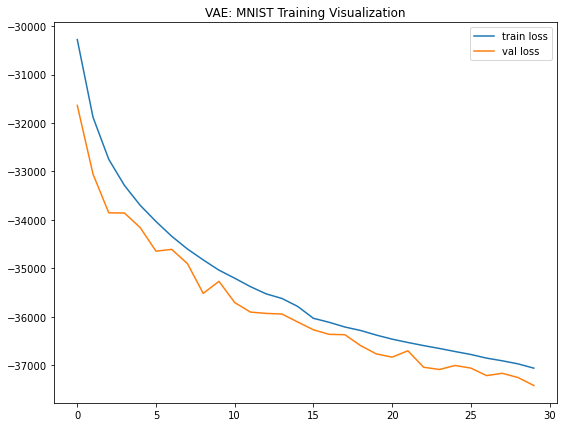

In [60]:
# Visualize training-
plt.figure(figsize = (9, 7))
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc = 'best')
plt.title("VAE: MNIST Training Visualization")
plt.show()

In [61]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [62]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 784]), torch.Size([64, 16]), torch.Size([64, 16]))

In [71]:
recon_images = recon_images.detach().numpy()

In [66]:
# Reshape reconstructed images for visualization-
recon_images = recon_images.view(-1, 1, 28, 28)

In [67]:
recon_images.shape, images.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

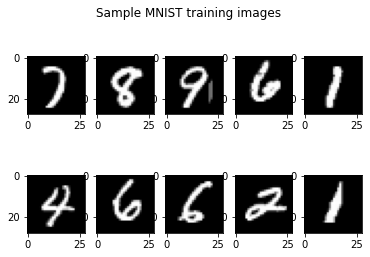

In [68]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

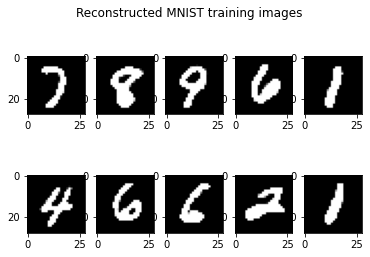

In [72]:
# Print 10 images from reconstructed images-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(recon_images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()

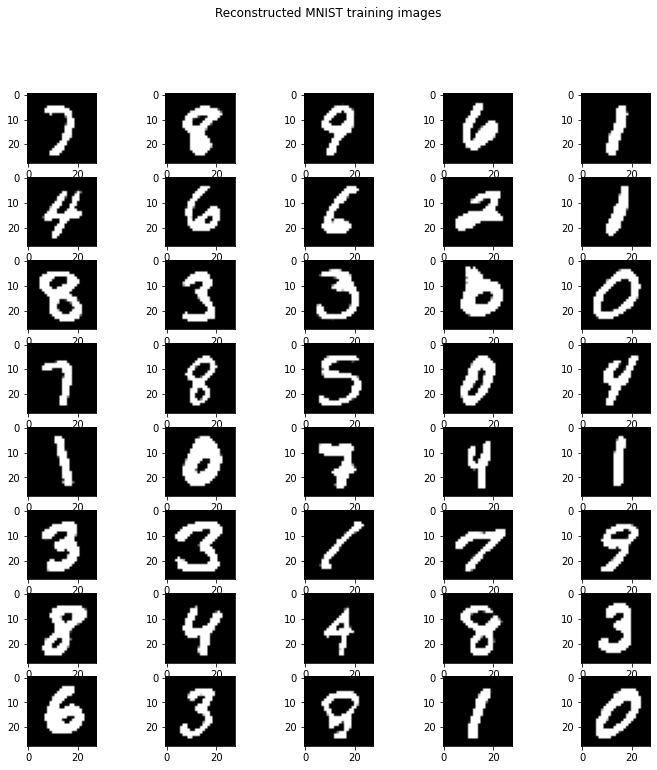

In [77]:
# Print 40 images from reconstructed images-
plt.figure(figsize = (12, 12))

for i in range(40):
    plt.subplot(8, 5, i + 1)    # 8 rows & 5 columns
    plt.imshow(recon_images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Reconstructed MNIST training images")
plt.show()

In [73]:
# Get latent space representation-
latent_space = model.reparameterize(mu, log_var)

In [74]:
latent_space = latent_space.detach().numpy()

In [75]:
latent_space.shape

(64, 16)